In [1]:
from rdflib import Graph

# Load your TTL file
g = Graph()
g.parse("merged_individuals_updated_v2.ttl", format="ttl")

<Graph identifier=N9f96ebcfbc95464c9487a0f99fbcacda (<class 'rdflib.graph.Graph'>)>

In [28]:
#imports
from rdflib import Graph, Literal, URIRef
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

## Query 1. Most Frequently Referenced Individuals

This query counts how often each individual appears in the graph—either as a subject or an object.  
It helps highlight which entities are most central or frequently referenced in the knowledge graph.

In [8]:
# SELECT ?ind (COUNT(?ind) AS ?count) 
# WHERE { 
#   ?ind a owl:NamedIndividual .
#   { ?ind ?p ?o } UNION 
#   { ?s ?p ?ind } 
# } 
# GROUP BY ?ind 
# ORDER BY DESC(?count)

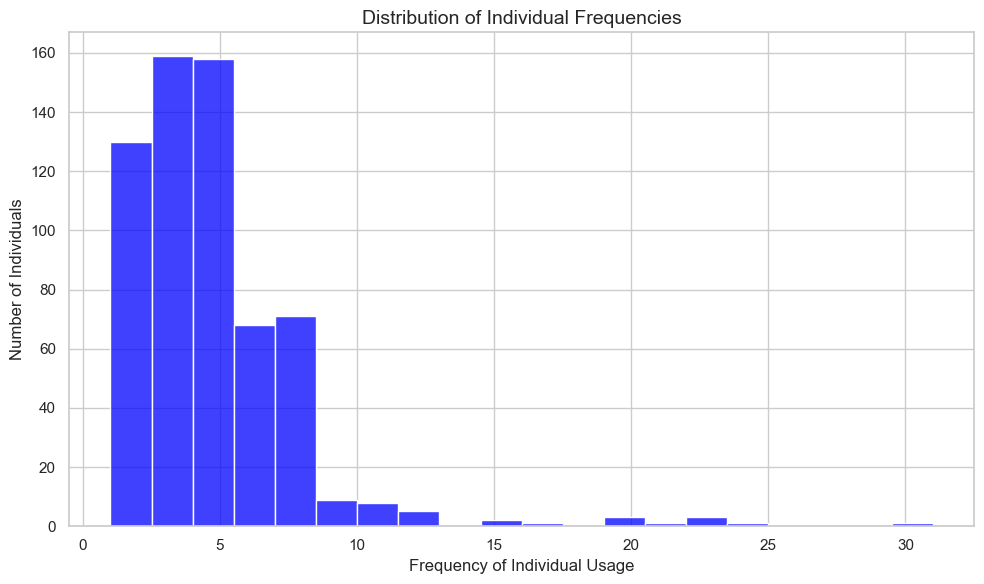

In [43]:
def QueryIndFreq(graph):
    res = graph.query("""
        SELECT ?ind (COUNT(?ind) AS ?count) 
        WHERE { 
            ?ind a owl:NamedIndividual . 
            { ?ind ?p ?o } UNION 
            { ?s ?p ?ind } 
        } 
        GROUP BY ?ind 
        ORDER BY DESC(?count)
    """, initNs={'owl': 'http://www.w3.org/2002/07/owl#'})
    
    df = pd.DataFrame(res, columns=["Instance", "Frequency"])
    df["Instance"] = df["Instance"].apply(lambda x: x.split("/")[-1] if isinstance(x, URIRef) else str(x))
    df["Frequency"] = df["Frequency"].apply(lambda x: int(str(x)) if isinstance(x, Literal) else x)
    return df

indivfreq = QueryIndFreq(g)
indivfreq.head()

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.histplot(indivfreq["Frequency"], kde=False, bins=20, color='blue')

plt.xlabel("Frequency of Individual Usage", fontsize=12)
plt.ylabel("Number of Individuals", fontsize=12)
plt.title("Distribution of Individual Frequencies", fontsize=14)
plt.tight_layout()
plt.savefig("Query_1", dpi=300, bbox_inches='tight')
plt.show()

## Query 2. Most Frequently Used Predicates 
This query counts how many times each predicate is used in the graph. This shows which relationships are most common.

In [ ]:
# SELECT DISTINCT ?pred (COUNT(?pred) AS ?count) 
# WHERE { 
#   ?s ?pred ?obj 
# } 
# GROUP BY ?pred 
# ORDER BY DESC(?count)

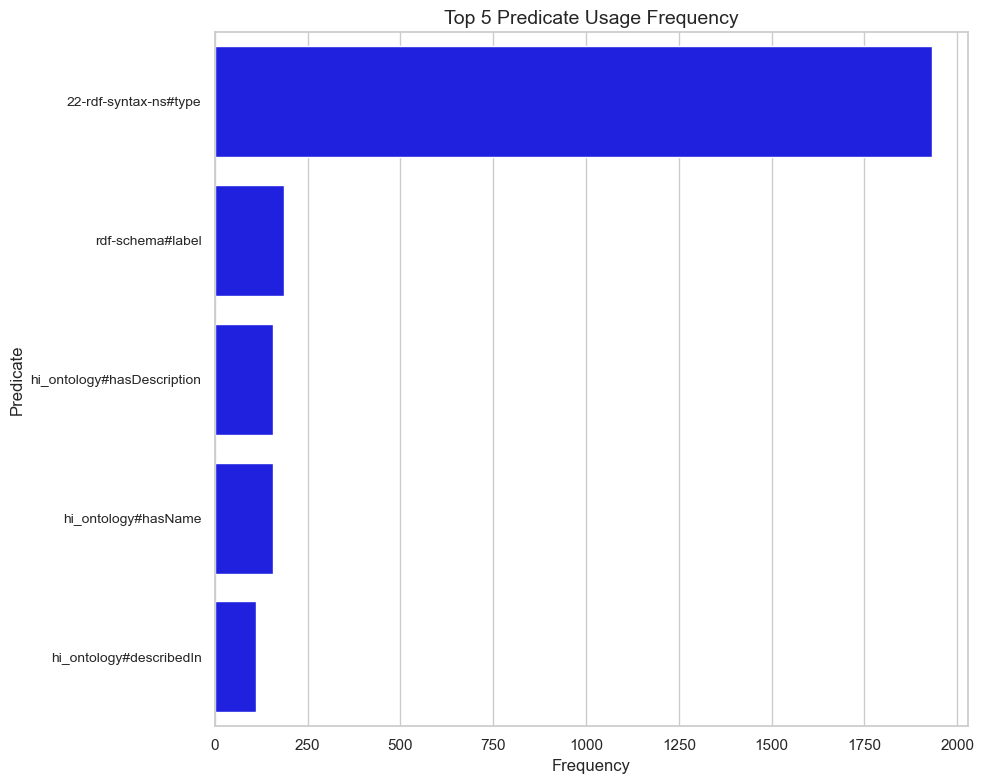

In [50]:
def QueryPredFreq(graph):
    res = graph.query("""
        SELECT DISTINCT ?pred (COUNT(?pred) AS ?count) 
        WHERE { ?s ?pred ?obj } 
        GROUP BY ?pred 
        ORDER BY DESC(?count)
    """)
    
    df = pd.DataFrame(res, columns=["Predicate", "Frequency"])
    df["Predicate"] = df["Predicate"].apply(lambda x: x.split("/")[-1] if isinstance(x, URIRef) else str(x))
    df["Frequency"] = df["Frequency"].apply(lambda x: int(str(x)) if isinstance(x, Literal) else x)
    return df

predfreq = QueryPredFreq(g)
predfreq.head()

# Sort the predicate frequency DataFrame by Frequency
predfreq_sorted = predfreq.sort_values(by="Frequency", ascending=False)

# plt.figure(figsize=(12, 6))
# sns.set(style="whitegrid")
# sns.barplot(data=predfreq_sorted, x="Predicate", y="Frequency", color='blue')

# plt.xlabel("Predicate", fontsize=12)
# plt.ylabel("Frequency", fontsize=12)
# plt.title("Predicate Usage Frequency", fontsize=14)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Use horizontal bar plot for better label readability
top_predfreq = predfreq_sorted.head(5)

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.barplot(data=top_predfreq, y="Predicate", x="Frequency", color='blue')

plt.ylabel("Predicate", fontsize=12)
plt.xlabel("Frequency", fontsize=12)
plt.title("Top 5 Predicate Usage Frequency", fontsize=14)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("Query_2", dpi=300, bbox_inches='tight')
plt.show()

## Query 3: Number of Instances per Class: 
Counts how many individuals belong to each class. This helps identify how well each conceptual category is populated.

In [ ]:
# SELECT ?class (COUNT(?instance) AS ?count)
# WHERE { 
#   ?instance a ?class 
# } 
# GROUP BY ?class 
# ORDER BY DESC(?count)

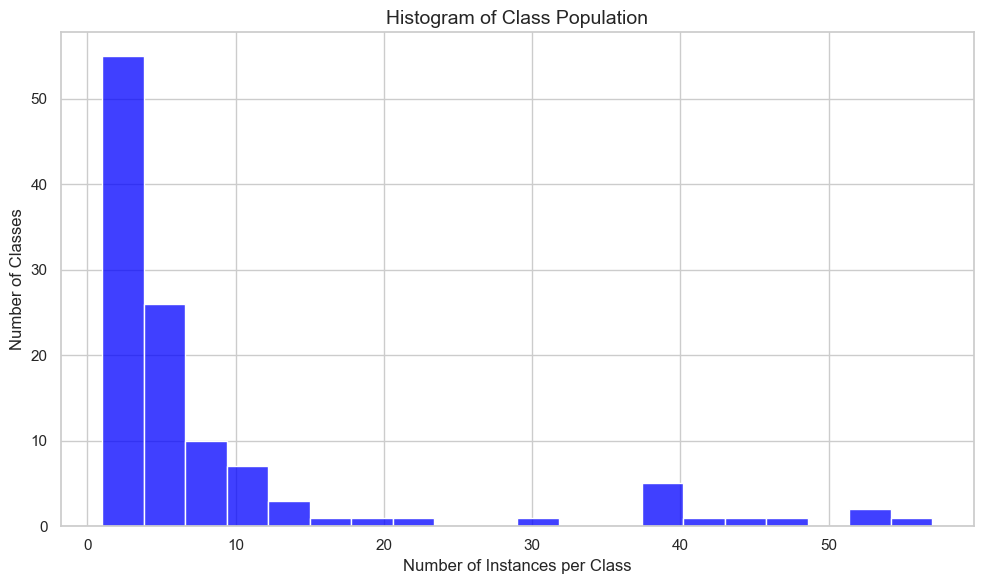

In [45]:
def QueryIndPerClass(graph):
    res = graph.query("""
        SELECT ?class (COUNT(?instance) AS ?count)
        WHERE { ?instance a ?class } 
        GROUP BY ?class 
        ORDER BY DESC(?count)
    """)
    
    df = pd.DataFrame(res, columns=["Class", "Frequency"])
    df["Class"] = df["Class"].apply(lambda x: x.split("/")[-1] if isinstance(x, URIRef) else str(x))
    df["Frequency"] = df["Frequency"].apply(lambda x: int(str(x)) if isinstance(x, Literal) else x)
    return df

indiv_per_class = QueryIndPerClass(g)
indiv_per_class.head()

def plot_instances_per_class(df):
    sns.set(style="whitegrid")
    filtered_df = df[~df["Class"].str.contains("owl#", na=False)]
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_df["Frequency"], bins=20, color='blue')
    plt.xlabel("Number of Instances per Class", fontsize=12)
    plt.ylabel("Number of Classes", fontsize=12)
    plt.title("Histogram of Class Population", fontsize=14)
    plt.tight_layout()
    plt.savefig("Query_3", dpi=300, bbox_inches='tight')
    plt.show()

plot_instances_per_class(indiv_per_class)

## Query 4. Individuals by Predicate Diversity

This query finds the individuals in the knowledge graph that are connected to the greatest variety of relationships.  
Instead of simply counting how many times an individual appears in the graph, it measures how many distinct types of predicates (relationships) they are involved in.

### How it works:
- It examines all triples in which an individual appears as either a subject or an object.
- For each such individual, it counts how many unique predicates they are associated with.
- It excludes `rdf:type`, as that predicate is mainly used to declare types (e.g., `:Paper a :Publication`) and doesn’t carry meaningful insight in this context.

### Why This is Useful:
This helps identify individuals that are semantically diverse —that is, connected through many different relationship types.  
Even if an individual doesn’t appear frequently, being linked through various predicates often makes it structurally central or conceptually rich.

### This query helps reveal:
1. Hubs in the knowledge graph—entities acting as key connectors.
2. High-information individuals that might need closer inspection or refinement.
3. Semantic density across parts of the graph, helping inform ontology refinement.

In [23]:
# SELECT ?individual (COUNT(DISTINCT ?predicate) AS ?numPredicates)
# WHERE {
#   ?individual a owl:NamedIndividual .
#   { ?individual ?predicate ?o . }
#   UNION
#   { ?s ?predicate ?individual . }
#   FILTER (?predicate != rdf:type)
# }
# GROUP BY ?individual
# ORDER BY DESC(?numPredicates)

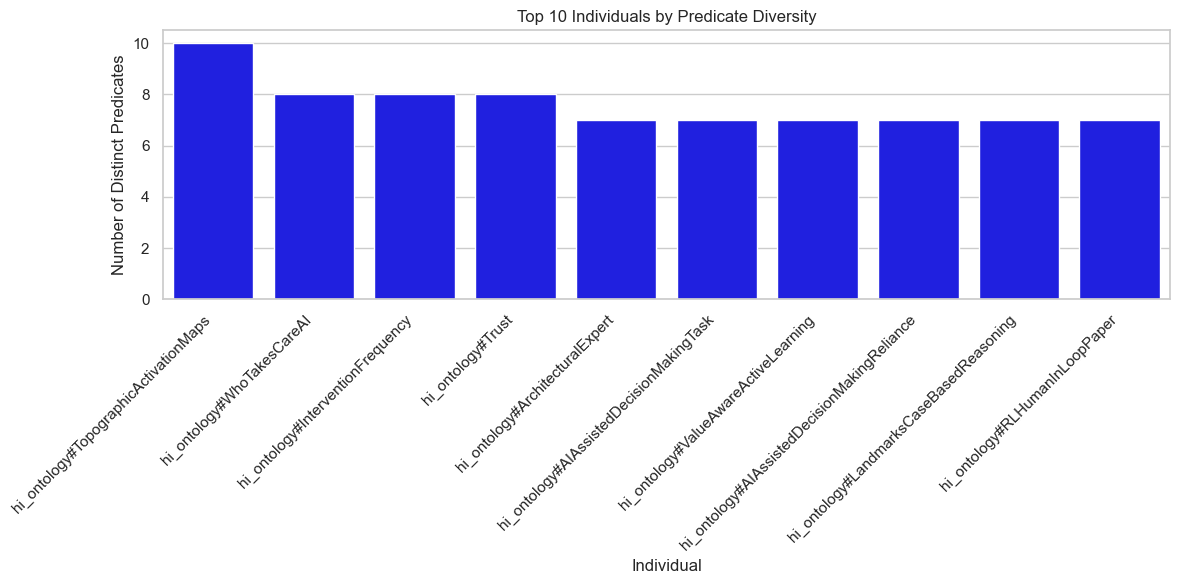

In [46]:
def query_top_individuals_by_predicates(graph, top_n=10):
    res = graph.query("""
        SELECT ?individual (COUNT(DISTINCT ?predicate) AS ?numPredicates)
        WHERE {
          ?individual a owl:NamedIndividual .
          { ?individual ?predicate ?o . }
          UNION
          { ?s ?predicate ?individual . }
          FILTER (?predicate != rdf:type)
        }
        GROUP BY ?individual
        ORDER BY DESC(?numPredicates)
    """, initNs={'owl': 'http://www.w3.org/2002/07/owl#', 'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#'})
    
    df = pd.DataFrame(res, columns=["Individual", "NumPredicates"])
    df["Individual"] = df["Individual"].apply(lambda x: x.split("/")[-1] if isinstance(x, URIRef) else str(x))
    df["NumPredicates"] = df["NumPredicates"].apply(lambda x: int(str(x)) if isinstance(x, Literal) else x)

    plt.figure(figsize=(12, 6))
    top_df = df.head(top_n)
    sns.barplot(data=top_df, x="Individual", y="NumPredicates", color= 'blue')
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Top {top_n} Individuals by Predicate Diversity")
    plt.xlabel("Individual")
    plt.ylabel("Number of Distinct Predicates")
    plt.tight_layout()
    plt.savefig("Query_4", dpi=300, bbox_inches='tight')
    plt.show()

    return df

top_predicate_diversity = query_top_individuals_by_predicates(g)

## Query 5. Frequent Class Interaction Patterns

### How it Works:

This query analyzes how instances of one class are connected to instances of another class in the knowledge graph.

More specifically:

1. It looks for triples where:
   - `?subject` has some relationship (any predicate `?p`) to `?object`.

2. It checks the class of the subject and object:
   - `?subject a ?class1`
   - `?object a ?class2`

3. It filters out connections where either class is just `owl:NamedIndividual`, since that is a generic type that doesn’t provide useful insight.

4. It counts how many times each class-to-class pair appears—i.e., how many times instances of one class are linked to instances of another.

### Why This Is Useful

This query reveals the most frequent connections between classes in our ontology. It highlights structural patterns like:

- “Instances of `Author` are frequently connected to `Paper`”
- “`Tool` is often linked to `Framework`”
- “`Task` frequently connects to `Dataset`”

These patterns helps in understanding the semantic architecture of the knowledge graph and how different conceptual categories interact at the class level.

In [24]:
# SELECT ?class1 ?class2 (COUNT(*) AS ?count)
# WHERE {
#   ?subject ?p ?object .
#   ?subject a ?class1 .
#   ?object a ?class2 .
#   FILTER (?class1 != owl:NamedIndividual && ?class2 != owl:NamedIndividual)
# }
# GROUP BY ?class1 ?class2
# ORDER BY DESC(?count)

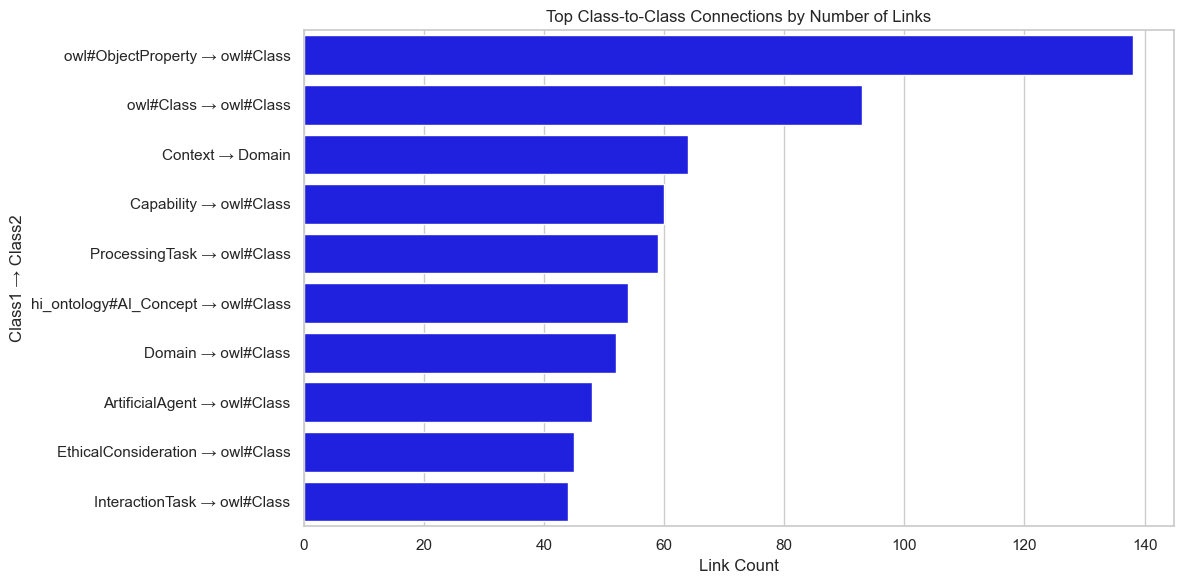

,Class1,Class2,Count
0,owl#ObjectProperty,owl#Class,138
1,owl#Class,owl#Class,93
2,Context,Domain,64
3,Capability,owl#Class,60
4,ProcessingTask,owl#Class,59
5,hi_ontology#AI_Concept,owl#Class,54
6,Domain,owl#Class,52
7,ArtificialAgent,owl#Class,48
8,EthicalConsideration,owl#Class,45
9,InteractionTask,owl#Class,44


In [47]:
def query_class_link_frequency(graph, top_n=10):
    query = """
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

    SELECT ?class1 ?class2 (COUNT(*) AS ?count)
    WHERE {
      ?subject ?p ?object .
      ?subject a ?class1 .
      ?object a ?class2 .
      FILTER (?class1 != owl:NamedIndividual && ?class2 != owl:NamedIndividual)
    }
    GROUP BY ?class1 ?class2
    ORDER BY DESC(?count)
    """

    results = graph.query(query)

    df = pd.DataFrame(results, columns=["Class1", "Class2", "Count"])
    
    # Clean class URIs
    for col in ["Class1", "Class2"]:
        df[col] = df[col].apply(lambda x: x.split("/")[-1] if isinstance(x, URIRef) else str(x))

    df["Count"] = df["Count"].apply(lambda x: int(str(x)) if isinstance(x, Literal) else x)
    df = df.sort_values("Count", ascending=False).head(top_n)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="Count", y=df["Class1"] + " → " + df["Class2"], color = 'blue')
    plt.title("Top Class-to-Class Connections by Number of Links")
    plt.xlabel("Link Count")
    plt.ylabel("Class1 → Class2")
    plt.tight_layout()
    plt.savefig("Query_5", dpi=300, bbox_inches='tight')
    plt.show()

    return df

query_class_link_frequency(g)

## Query 6. Classes Where Individuals Are Interlinked

### How it Works:

This SPARQL query analyzes intra-class relationships — that is, it checks how often individuals that belong to the same class are connected to each other via some property.

1. **Triple pattern** `?s ?p ?o`  
   Finds relationships between two individuals in the graph.

2. **Class membership**:  
   Ensures both the subject `?s` and the object `?o` belong to the same class using:  
   `?s a ?class .` and `?o a ?class .`

3. **Filter out self-links**:  
   `FILTER (?s != ?o)` removes connections where an individual links to itself.

4. **Filter out type declarations**:  
   `FILTER (?p != rdf:type)` excludes uninformative triples like `:x rdf:type :Class`.

5. **Group and count**:  
   The results are grouped by class, and the number of such intra-class connections is counted.


### Why This is Useful:

This query highlights classes where instances are densely connected with one another. These intra-class links can reveal:

- Collaboration or influence among entities (e.g., `Person -> Person`, `Tool -> Tool`)
- Feedback or recursive structures within a domain (e.g., `Concept -> Concept`)
- Useful candidates for further subgraph analysis or visual community detection


In [30]:
# SELECT ?class (COUNT(*) AS ?count)
# WHERE {
#   ?s a ?class .
#   ?o a ?class .
#   ?s ?p ?o .
#   FILTER (?s != ?o && ?p != rdf:type)
# }
# GROUP BY ?class
# ORDER BY DESC(?count)

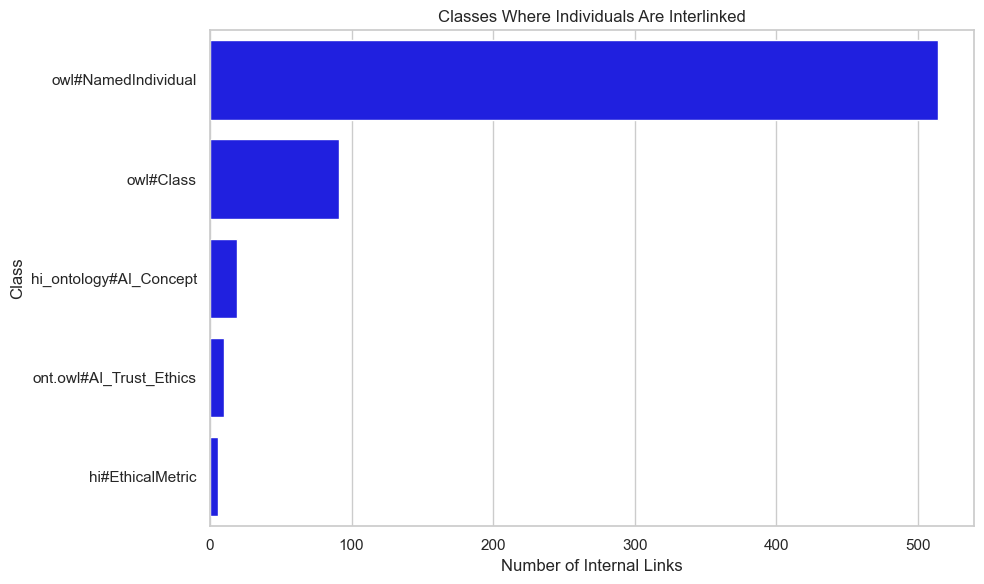

,Class,Count
0,owl#NamedIndividual,514
1,owl#Class,91
2,hi_ontology#AI_Concept,19
3,ont.owl#AI_Trust_Ethics,10
4,hi#EthicalMetric,6


In [49]:
def query_same_class_linked_individuals(graph, top_n=5):
    query = """
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

    SELECT ?class (COUNT(*) AS ?count)
    WHERE {
      ?s a ?class .
      ?o a ?class .
      ?s ?p ?o .
      FILTER (?s != ?o && ?p != rdf:type)
    }
    GROUP BY ?class
    ORDER BY DESC(?count)
    """

    results = graph.query(query)

    df = pd.DataFrame(results, columns=["Class", "Count"])
    
    df["Class"] = df["Class"].apply(lambda x: x.split("/")[-1] if isinstance(x, URIRef) else str(x))
    df["Count"] = df["Count"].apply(lambda x: int(str(x)) if isinstance(x, Literal) else x)

    df = df.sort_values("Count", ascending=False).head(top_n)


    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="Count", y="Class", color = 'blue')
    plt.title("Classes Where Individuals Are Interlinked")
    plt.xlabel("Number of Internal Links")
    plt.ylabel("Class")
    plt.tight_layout()
    plt.savefig("Query_6", dpi=300, bbox_inches='tight')
    plt.show()

    return df

query_same_class_linked_individuals(g)